<a href="https://colab.research.google.com/github/AzraSaf/NutriSense/blob/main/azra_work/Final_Leaf_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
import zipfile
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
import tempfile
import os
import torch
import zipfile
import shutil
from sklearn.model_selection import train_test_split
from collections import Counter
import tempfile
import shutil
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

 Mount Google Drive & Set Random Seeds

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
tf.random.set_seed(42)
random.seed(42)


Mounted at /content/drive


Extract and Load Dataset

In [3]:
# Paths to zip files
leaf_zip = '/content/drive/My Drive/leaf_dataset.zip'
NegSamples_zip = '/content/drive/My Drive/NegSamples.zip'

# Common extraction directory
combined_dataset_path = '/content/combined_dataset/'

# Function to extract a zip file
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extract both datasets
extract_zip(leaf_zip, '/content/leaf_extracted/')
extract_zip(NegSamples_zip, '/content/NegSamples_extracted/')

# Get leaf dataset folder
leaf_main_folder = os.path.join('/content/leaf_extracted/', os.listdir('/content/leaf_extracted/')[0])

# Get NegSamples dataset folder (check if it's an image or a folder)
NegSamples_main_folder = '/content/NegSamples_extracted/'

# Check if NegSamples_main_folder contains images directly
NegSamples_file = [f for f in os.listdir(NegSamples_main_folder) if os.path.isfile(os.path.join(NegSamples_main_folder, f))]

if NegSamples_file:
    # Create a class folder for NegSamples if it doesn’t exist
    NegSamples_class_folder = os.path.join(NegSamples_main_folder, "wheat")
    os.makedirs(NegSamples_class_folder, exist_ok=True)

    # Move all NegSamples images into the new "NegSample" folder
    for img in NegSamples_file:
        shutil.move(os.path.join(NegSamples_main_folder, img), os.path.join(NegSamples_class_folder, img))

    # Update NegSamples_main_folder to point to the new class folder
    NegSamples_main_folder = NegSamples_class_folder

# Ensure the combined dataset directory exists
os.makedirs(combined_dataset_path, exist_ok=True)

# Function to merge datasets (only merges folders, ignores files)
def merge_datasets(source_folder, target_folder):
    for class_name in os.listdir(source_folder):
        class_source = os.path.join(source_folder, class_name)

        # Only process directories, skip files like "lolr(155).JPG"
        if not os.path.isdir(class_source):
            continue  # Skip files

        class_target = os.path.join(target_folder, class_name)
        os.makedirs(class_target, exist_ok=True)

        # Move images to the combined dataset
        for img in os.listdir(class_source):
            img_source = os.path.join(class_source, img)
            img_target = os.path.join(class_target, img)

            #Only move actual image files
            if os.path.isfile(img_source):
                shutil.move(img_source, img_target)

# Call merge function again
merge_datasets(leaf_main_folder, combined_dataset_path)
merge_datasets(NegSamples_main_folder, combined_dataset_path)

# Now re-check the dataset
species_classes = [d for d in os.listdir(combined_dataset_path) if os.path.isdir(os.path.join(combined_dataset_path, d))]
print("Final species classes:", species_classes)


Final species classes: ['NegSamples', 'Banana', 'Coffee', 'Rice']


Load Pretrained ResNet50 Model for Feature Extraction

In [4]:
# Image parameters
img_size = (224, 224)

# Load ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Define Data Generators for Preprocessing

In [5]:
# Data augmentation only for the training set
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 normalization
    brightness_range=[1.0, 1.2],  # Adjust brightness
    horizontal_flip=True          # Flip left-right
)

# No augmentation for validation and test sets
datagen_val_test = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create separate generators for training, validation, and test sets
data_generator = datagen_val_test.flow_from_directory(
    combined_dataset_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    classes=species_classes,
    shuffle=False
)


Found 5449 images belonging to 4 classes.


Extract Features from Images

In [6]:
# Extract features and labels from the generator
def extract_features(generator):
    features, labels = [], []
    for batch_images, batch_labels in generator:
        feature_batch = model.predict(batch_images)
        features.append(feature_batch)
        labels.append(batch_labels)
        if generator.batch_index == len(generator) - 1:
            break
    return np.vstack(features), np.vstack(labels)

# Extract features from the dataset
features, labels = extract_features(data_generator)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

Prepare Train, Validation, and Test Sets & Balance the Dataset by Augmenting Underrepresented Classes

In [7]:
# Convert one-hot encoded labels into class indices
y_train_class_indices = np.argmax(labels, axis=1)

# Count samples per class in the training set
train_class_counts = Counter(y_train_class_indices)
print("Class counts in the training set:", train_class_counts)

# Determine the maximum class count
max_count = max(train_class_counts.values())

# Step 1: Define temp_dir **before using it**
temp_dir = tempfile.mkdtemp()

# Step 2: Balance dataset before creating the generator
for species_index, count in train_class_counts.items():
    species = species_classes[species_index]
    species_dir = os.path.join(temp_dir, species)
    os.makedirs(species_dir, exist_ok=True)
    source_dir = os.path.join(combined_dataset_path, species)

    # Copy original images
    for file in os.listdir(source_dir):
        shutil.copy(os.path.join(source_dir, file), os.path.join(species_dir, file))

    # Augment underrepresented classes
    if count < max_count:
        datagen_augment = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            brightness_range=[0.8, 1.2],
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
        augmentation_generator = datagen_augment.flow_from_directory(
            temp_dir,  # Use temp_dir here, NOT combined_dataset_path
            target_size=img_size,
            batch_size=32,
            class_mode='categorical',
            classes=[species],
            shuffle=True
        )

        images_generated = 0
        while images_generated + count < max_count:
            batch_images, _ = next(augmentation_generator)
            for i in range(len(batch_images)):
                img_path = os.path.join(species_dir, f"aug_{images_generated + i}.jpg")
                tf.keras.utils.save_img(img_path, batch_images[i])
            images_generated += len(batch_images)
            if images_generated + count >= max_count:
                break

print("Augmentation completed. Balanced dataset created.")

# Step 3: Create balanced generator AFTER dataset is balanced
balanced_generator = datagen_val_test.flow_from_directory(
    temp_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Extract features from the balanced dataset
balanced_features, balanced_labels = extract_features(balanced_generator)

# Stratified split into train (70%), test (20%), and validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    balanced_features, balanced_labels, test_size=0.3, stratify=balanced_labels, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.333, stratify=y_temp, random_state=42
)

Class counts in the training set: Counter({np.int64(0): 1928, np.int64(1): 1406, np.int64(3): 1204, np.int64(2): 902})
Found 1406 images belonging to 1 classes.
Found 902 images belonging to 1 classes.
Found 1213 images belonging to 1 classes.
Augmentation completed. Balanced dataset created.
Found 7759 images belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━

Build and Train the Classifier

In [8]:
# Build the classifier
classifier = tf.keras.Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(len(species_classes), activation='softmax')
])

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
history = classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9251 - loss: 0.2604 - val_accuracy: 0.9961 - val_loss: 0.0112
Epoch 2/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9978 - loss: 0.0100 - val_accuracy: 0.9948 - val_loss: 0.0192
Epoch 3/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9928 - loss: 0.0157 - val_accuracy: 0.9948 - val_loss: 0.0240
Epoch 4/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9920 - loss: 0.0344 - val_accuracy: 0.9987 - val_loss: 0.0092
Epoch 5/5
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9986 - loss: 0.0041 - val_accuracy: 0.9987 - val_loss: 0.0047


Evaluate Model Performance

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0017
Validation Accuracy: 99.87%
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Validation Set Classification Report:
              precision    recall  f1-score   support

  NegSamples       1.00      1.00      1.00       195
      Banana       1.00      0.99      1.00       193
      Coffee       0.99      1.00      1.00       193
        Rice       1.00      1.00      1.00       193

    accuracy                           1.00       774
   macro avg       1.00      1.00      1.00       774
weighted avg       1.00      1.00      1.00       774



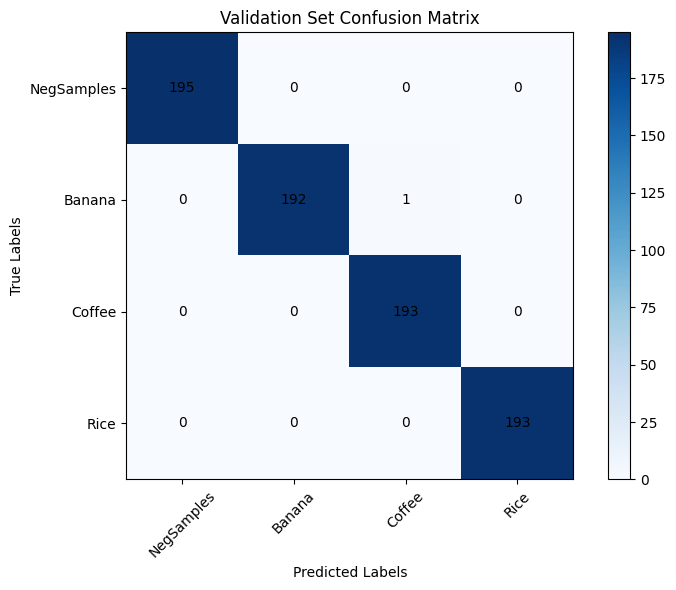

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 9.0380e-04
Test Accuracy: 99.87%
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Test Set Classification Report:
              precision    recall  f1-score   support

  NegSamples       1.00      1.00      1.00       390
      Banana       1.00      1.00      1.00       387
      Coffee       1.00      1.00      1.00       386
        Rice       1.00      1.00      1.00       387

    accuracy                           1.00      1550
   macro avg       1.00      1.00      1.00      1550
weighted avg       1.00      1.00      1.00      1550



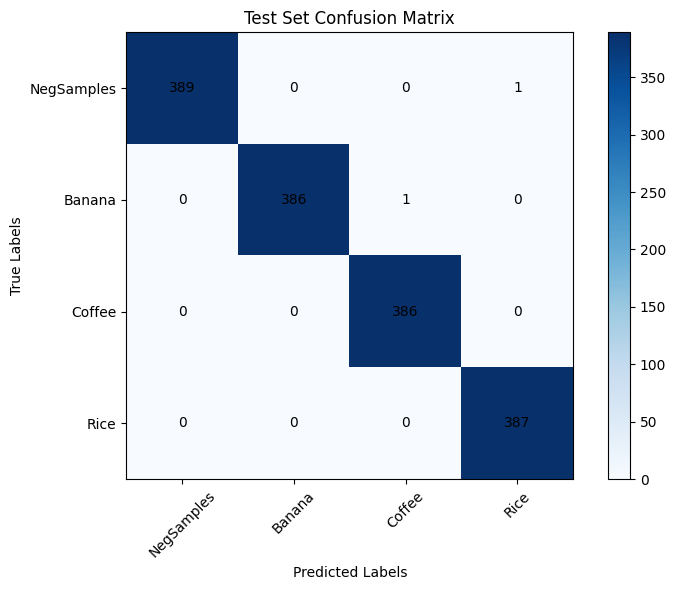

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Validation Accuracy
val_loss, val_accuracy = classifier.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Validation Set Classification Report
y_val_pred = classifier.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

print("\nValidation Set Classification Report:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=species_classes))

# Validation Set Confusion Matrix with Values
val_conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(val_conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(np.arange(len(species_classes)), species_classes, rotation=45)
plt.yticks(np.arange(len(species_classes)), species_classes)

# Add text annotations
for i in range(len(species_classes)):
    for j in range(len(species_classes)):
        plt.text(j, i, str(val_conf_matrix[i, j]), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# Test Accuracy
test_loss, test_accuracy = classifier.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Test Set Classification Report and Confusion Matrix
y_test_pred = classifier.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

print("\nTest Set Classification Report:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=species_classes))

# Test Set Confusion Matrix with Values
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(np.arange(len(species_classes)), species_classes, rotation=45)
plt.yticks(np.arange(len(species_classes)), species_classes)

# Add text annotations
for i in range(len(species_classes)):
    for j in range(len(species_classes)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


ROC Curves

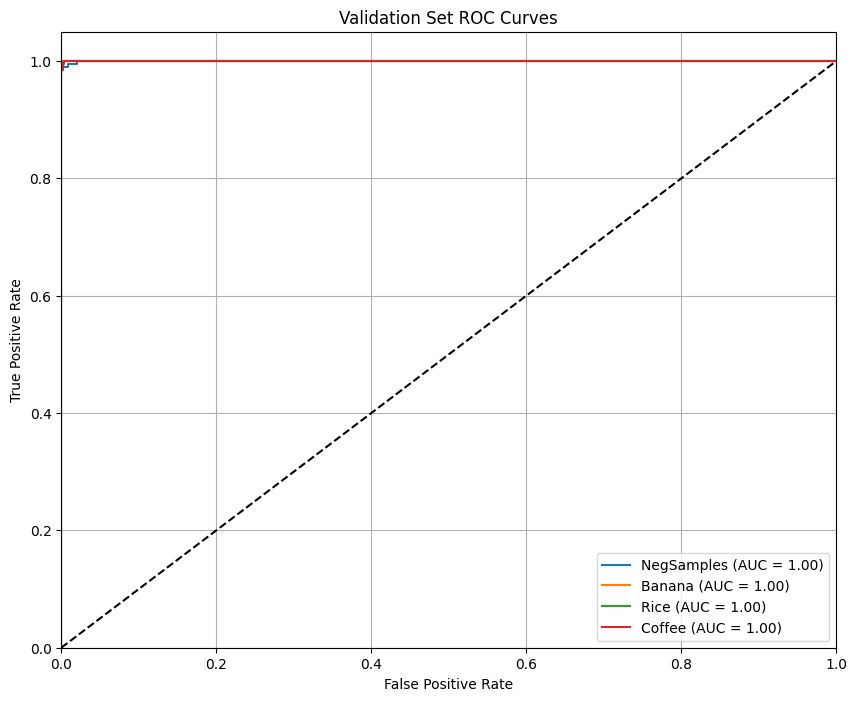

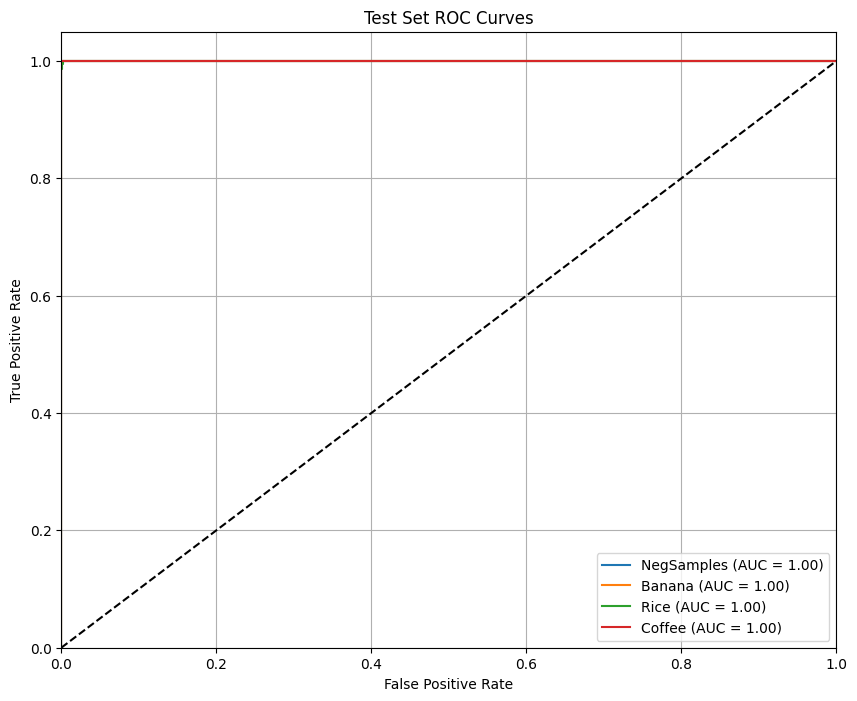

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
y_val_bin = label_binarize(y_val_true_classes, classes=list(range(len(species_classes))))
y_val_score = y_val_pred  # Already softmax output from model

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(species_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(species_classes)):
    plt.plot(fpr[i], tpr[i], label=f"{species_classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation Set ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Binarize the test labels
y_test_bin = label_binarize(y_test_true_classes, classes=list(range(len(species_classes))))
y_test_score = y_test_pred  # Already softmax output from model

# Compute ROC curve and ROC area for each class
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

for i in range(len(species_classes)):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Plot ROC curves
plt.figure(figsize=(6, 8))
for i in range(len(species_classes)):
    plt.plot(fpr_test[i], tpr_test[i], label=f"{species_classes[i]} (AUC = {roc_auc_test[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test Set ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Loss & Accuracy Curves

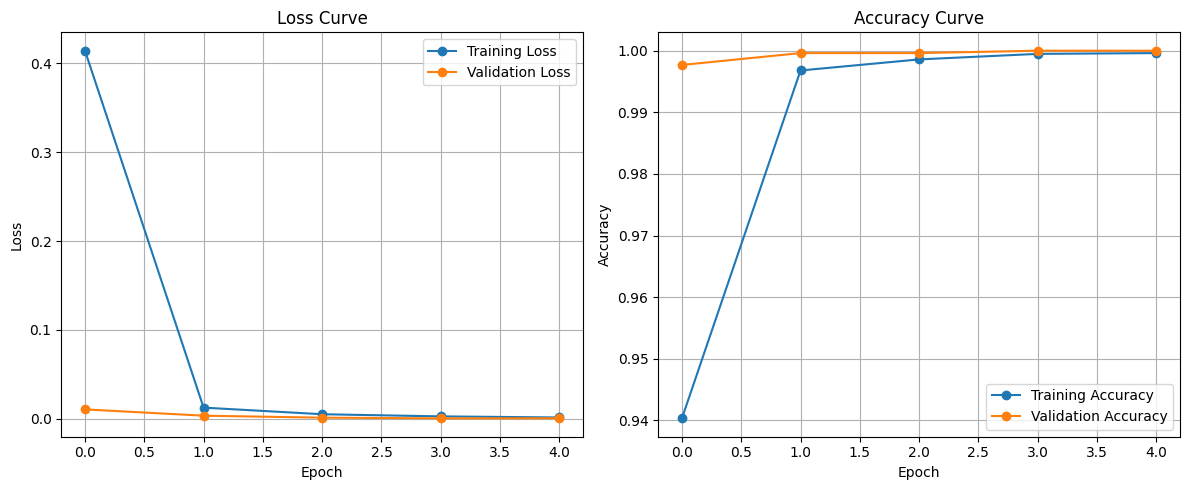

In [12]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Download the model for deployment

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load ResNet50 as the feature extractor
base_model = tf.keras.applications.ResNet50(
    include_top=False,  # Exclude fully connected layers
    weights='imagenet',  # Use pre-trained weights
    input_shape=(224, 224, 3)  # Ensure correct input shape
)
base_model.trainable = False  # Freeze base model

# Build the complete model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Pass raw images through ResNet50
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a vector
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(species_classes), activation='softmax')(x)

# Define and compile the model
complete_model = Model(inputs, outputs)
complete_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure data generator is correct
complete_data_generator = datagen_val_test.flow_from_directory(
    temp_dir,
    target_size=(224, 224),  # Ensure input size matches model
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Train the model
history = complete_model.fit(
    complete_data_generator,
    epochs=5,
    validation_data=complete_data_generator  # Use generator for validation too
)

# Save the model
complete_model.save("plant_identification_full_model.h5")
from google.colab import files
files.download("plant_identification_full_model.h5")

# Save class indices
class_indices = complete_data_generator.class_indices
with open('class_indices.txt', 'w') as f:
    f.write(str(class_indices))
files.download('class_indices.txt')

# Print class mapping
print("\nClass Indices:")
for class_name, index in class_indices.items():
    print(f"{class_name}: {index}")
